### Import Packages

In [ ]:
import pandas                  as     pd
import numpy                   as     np
import seaborn                 as     sns
import os 
import matplotlib.pyplot       as     plt
from   utils_text_clf          import utils_text_clf as utils
from   sklearn.model_selection import StratifiedKFold, \
                                      cross_validate, \
                                      cross_val_predict, \
                                      GridSearchCV
from   sklearn.pipeline        import Pipeline                            
from   sklearn.preprocessing   import StandardScaler, \
                                      RobustScaler, \
                                      MinMaxScaler
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.linear_model    import LogisticRegression
from   sklearn.svm             import LinearSVC, SVC
from   sklearn.neighbors       import KNeighborsClassifier
from   sklearn.naive_bayes     import GaussianNB
from   sklearn.ensemble        import RandomForestClassifier, \
                                      AdaBoostClassifier, \
                                      GradientBoostingClassifier
from   sklearn.manifold        import TSNE
from   sklearn.decomposition   import PCA
import xgboost                 as     xgb
from   sklearn.metrics         import roc_curve
from   scipy                   import interp
from   pathlib                 import Path
from   pickle                  import dump
import joblib

# Turn interactive plotting off
plt.ion()  
import warnings
warnings.filterwarnings("ignore")

### Run feature engineering

In [ ]:
#%% run feature engineering code 
%run feature_engineering.py
print('done!')

### Enter mutable info

In [2]:
#%% Enter mutable info

data_dir    = os.path.join(os.getcwd(), 'data')
results_dir = os.path.join(os.getcwd(), 'results')

# training data 
#file_train = 'train.jsonl'

# training data
file_train  = 'train_feature_engineering.csv';
file_test   = 'test_feature_engineering.csv'

#file_train = os.path.join(data_dir, file_train) 
file_train  = os.path.join(data_dir, file_train) 
file_test   = os.path.join(data_dir, file_test)

### Load in data 

In [3]:
#%% load in data 

#df_train = utils.parse_json(file_train)
df_train  = pd.read_csv(file_train)

# feats
x_train  = df_train.iloc[:, 1:]

# labels 
y_train  = df_train.label

# convert labels to binary (1 - sarcasm)
y_train  = [1 if i == 'SARCASM' else 0 for i in y_train]

In [4]:
#%% check label proportions 

# print count
print('The count of sarcastic tweets is:', y_train.count(1))
print('The count of non-sarcastic tweets is:', y_train.count(0))

The count of sarcastic tweets is: 2500
The count of non-sarcastic tweets is: 2500


In [5]:
# check the size of the training data 
x_train.shape

(5000, 15)

In [10]:
# compute PCAs
x_train_scaled = StandardScaler().fit_transform(x_train)
pca            = PCA().fit(x_train_scaled)
print('pca done!')

pca done!


In [11]:
# variance explained 
var_exp = np.cumsum(pca.explained_variance_ratio_)

# num of components 
n_comp  = range(len(var_exp))

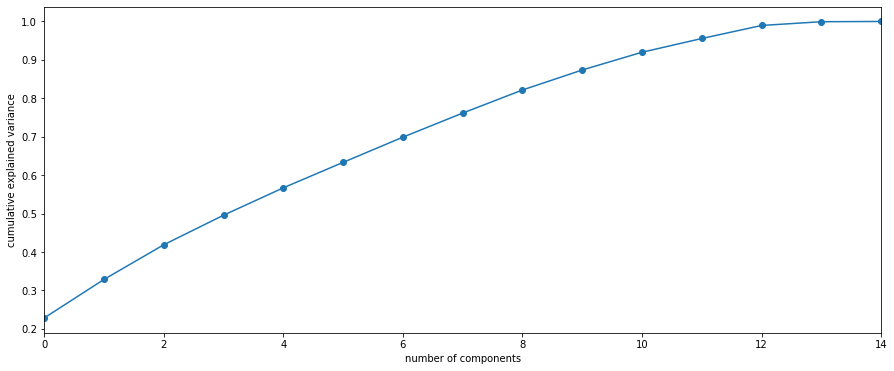

In [12]:
# plot explained variance vs. # of components 
ax = plt.figure(figsize = (15, 6))
plt.plot(n_comp, var_exp, '-o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance') 
plt.autoscale(enable = True, axis = 'x', tight = True)

There isn't a clear 'elbow' in the curve

Find # of PCA components needed to explain 90% of variance in the data 

In [13]:
n_pca = np.where(var_exp >= 0.9)[0][0]
print(n_pca)

10


In [ ]:
# save session 
import dill 
dill.dump_session('nb_pca_complete.db')
print('session saved!')

In [ ]:
# load session 
import dill 
dill.load_session('nb_pca_complete.db')
print('session loaded!')

In [ ]:
# represent data using pca feats 
# x_train_pca = PCA(n_components = n_pca).fit_transform(x_train_scaled)

In [ ]:
# x_train_pca.shape

In [6]:
# visualize features in low-dimensional space
tsne     = TSNE(n_components = 3, learning_rate = 100, random_state = 42)

# transform on data 
tsne_obj = tsne.fit_transform(x_train)

# put results into a df
tsne_df  = pd.DataFrame({'x' : tsne_obj[:,0], 
                         'y' : tsne_obj[:,1], 
                         'z' : tsne_obj[:,2], 
                         'label': y_train})

In [ ]:
# save session 
import dill 
dill.dump_session('nb_tsne_complete.db')
print('session saved!')

In [ ]:
# load session 
import dill 
dill.load_session('nb_tsne_complete.db')
print('session loaded!')

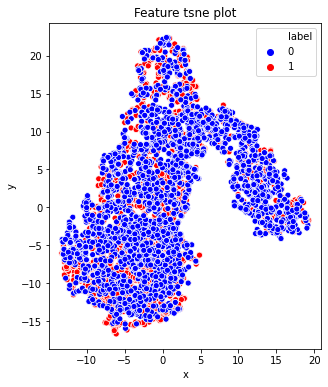

<Figure size 432x288 with 0 Axes>

In [7]:
#%% 2D scattrplot 
ax = plt.figure(figsize = (15, 6))
sns.scatterplot(x = "x", y = "y", hue = "label", palette = ["blue", "red"], 
                legend = 'full', data = tsne_df);
plt.title('Feature tsne plot')
plt.gca().set_aspect('equal', adjustable = 'box')

fig_name  = 'feat_tsne_plot_2d.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()
plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(fig_file)

In [8]:
#%% 3D scatterplot 
from mpl_toolkits.mplot3d import axes3d    
%matplotlib qt 
ax = plt.figure(figsize=(16,10)).gca(projection = '3d')

ax.scatter(xs    = tsne_df.loc[tsne_df['label'] == 0]["x"],
           ys    = tsne_df.loc[tsne_df['label'] == 0]["y"],
           zs    = tsne_df.loc[tsne_df['label'] == 0]["z"],
           c     = 'blue', 
           label = '0') 

ax.scatter(xs    = tsne_df.loc[tsne_df['label'] == 1]["x"],
           ys    = tsne_df.loc[tsne_df['label'] == 1]["y"],
           zs    = tsne_df.loc[tsne_df['label'] == 1]["z"],
           c     = 'red',
           label = '1') 

ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3')

plt.title('feat tsne scatterplot')
plt.legend()
plt.show()

fig_name  = 'feat_tsne_plot_3d.pickle'
fig_file  = os.path.join(results_dir, fig_name)

# save figure 
output    = open(fig_file, 'wb')
dump(plt.gcf(), output)
output.close()

In [9]:
%matplotlib inline

In [14]:
# create base models 

# decision tree
dtree_clf     = DecisionTreeClassifier(class_weight = 'balanced', 
                                       random_state = 42)
dtree         = Pipeline([('scaler',    StandardScaler()), 
                          ('dtree_clf', dtree_clf)]) 

# logistic regression 
logreg_clf    = LogisticRegression(n_jobs       = -1, 
                                   class_weight = 'balanced', 
                                   random_state = 42)
logreg        = Pipeline([('scaler',     StandardScaler()),
                          ('logreg_clf', logreg_clf)]) 

# linear SVM
svc_lin_clf   = LinearSVC(max_iter     = 20000, 
                          class_weight = 'balanced', 
                          random_state = 42)
svc_lin       = Pipeline([('scaler',      StandardScaler()),
                          ('svc_lin_clf', svc_lin_clf)]) 

# rbf kernel SVM
svc_rbf_clf   = SVC(kernel       = 'rbf', 
                    C            = 1, 
                    gamma        = 'auto', 
                    probability  = True, 
                    max_iter     = 20000, 
                    random_state = 42)
svc_rbf       = Pipeline([('scaler',      StandardScaler()),
                          ('svc_rbf_clf', svc_rbf_clf)]) 

# naive Bayes 
NB_clf        = GaussianNB()
NB            = Pipeline([('scaler', StandardScaler()),
                          ('NB_clf', NB_clf)]) 

# KNN
knn_clf       = KNeighborsClassifier(n_jobs       = -1)
knn           = Pipeline([('scaler',  StandardScaler()),
                          ('knn_clf', knn_clf)]) 

# random forest classifier
rndf_clf      = RandomForestClassifier(n_estimators   = 250,  
                                       max_leaf_nodes = 16, 
                                       n_jobs         = -1, 
                                       class_weight   = 'balanced', 
                                       random_state   = 42)
rndf          = Pipeline([('scaler',   StandardScaler()),
                          ('rndf_clf', rndf_clf)]) 

# xgboost
xgb_clf       = xgb.XGBClassifier(seed = 42)
xgb           = Pipeline([('scaler',  StandardScaler()),
                          ('xgb_clf', xgb_clf)]) 

# stochastic gradient boosting
gb_clf        = GradientBoostingClassifier(random_state = 42)
gb            = Pipeline([('scaler',  StandardScaler()),
                          ('gb_clf',  gb_clf)])

# adaboost
adb_clf       = AdaBoostClassifier(random_state = 42)
adb           = Pipeline([('scaler',  StandardScaler()),
                          ('adb_clf', adb_clf)]) 

#%% create model pipeline 

# Append models 
models        = [] 
models.append(['DTREE' , dtree])
models.append(['LOGREG', logreg])
models.append(['SVCLIN', svc_lin])
models.append(['SVCRBF', svc_rbf])
models.append(['KNN'   , knn])
models.append(['NB'    , NB])
models.append(['RNDF'  , rndf])
models.append(['XGB'   , xgb])

In [15]:
#%% set cross validation metrics 

n_splits      = 10 # folds 
cv            = StratifiedKFold(n_splits = n_splits, random_state = 42)
scores        = ['accuracy', 'recall', 'precision', 'roc_auc', 'f1']

#%% prepare cross-validation storage

# define the columns of the cross-validation results dataframe 
xval_cols     = ['classifier', 
                 'recall', 
                 'precision',
                 'f1',
                 'accuracy',
                 'roc_auc']

roc_cols      = ['classifier', 'tpr', 'fpr']

# dataframe to store cross-validation results 
df_xval       = pd.DataFrame(index = range(n_splits), columns = xval_cols)
df_xval_all   = pd.DataFrame()
df_xval_roc   = pd.DataFrame()

In [16]:
#%% spot check models on training data 

# loop through the classifiers 

for i, (name, model) in enumerate(models): 

    # cross-validate and compute scores 
    score_results              = cross_validate(model, 
                                                x_train, 
                                                y_train, 
                                                scoring            = scores, 
                                                cv                 = cv, 
                                                return_train_score = False, 
                                                n_jobs             = -1)
    
    print(name + ' cross-validation completed')

    # clean up the df 
    score_results              = pd.DataFrame(score_results).loc[:,['test_accuracy', 'test_f1', 'test_recall', 'test_precision', 'test_roc_auc']]
    score_results.columns      = score_results.columns.str.replace('test_','')
    
    # store the metric results 
    for metric in score_results.columns:
        df_xval.loc[:, metric] = score_results[metric]
        
    # Fill in the 'classifier' column 
    df_xval['classifier']      = np.repeat(name, n_splits, axis = 0)

    # compute class prediction probabilities 
    if hasattr(model, 'predict_proba'):
        y_pred                 = cross_val_predict(model, 
                                                   x_train, 
                                                   y_train, 
                                                   cv     = cv, 
                                                   n_jobs = -1, 
                                                   method = 'predict_proba')
        print(name + ' cross_val_predict completed')
                
    # compute the fpr, tpr
    fpr_reg                    = np.linspace(0, 1, 501) # at regular ticks 
            
    fpr, tpr, _                = roc_curve(y_train, y_pred[:,1], pos_label = 1)
    tpr                        = interp(fpr_reg, fpr, tpr)
        
    # Store fpr, tpr
    run_dict                   = dict.fromkeys(roc_cols) 
    run_dict['fpr']            = list(fpr_reg)
    run_dict['tpr']            = list(tpr)
    run_dict['classifier']     = name

    # append to the roc results dataframe 
    df_xval_roc                = df_xval_roc.append(pd.Series(run_dict).to_frame().T, ignore_index = True) 

    # append to the overall cross-validation results dataframe 
    df_xval_all                = df_xval_all.append(df_xval, ignore_index = True)
    
print('all done!')


DTREE cross-validation completed
DTREE cross_val_predict completed
LOGREG cross-validation completed
LOGREG cross_val_predict completed
SVCLIN cross-validation completed
SVCRBF cross-validation completed
SVCRBF cross_val_predict completed
KNN cross-validation completed
KNN cross_val_predict completed
NB cross-validation completed
NB cross_val_predict completed
RNDF cross-validation completed
RNDF cross_val_predict completed
XGB cross-validation completed
XGB cross_val_predict completed


In [17]:
#%% review x-val results 

df_xval_all.groupby('classifier').mean()

,recall,precision,f1,accuracy,roc_auc
classifier,,,,,
DTREE,0.6292,0.657044,0.641566,0.6480,0.648158
KNN,0.7188,0.669308,0.692413,0.6796,0.727761
LOGREG,0.7932,0.682843,0.733112,0.7096,0.774586
NB,0.8220,0.637889,0.717912,0.6768,0.742776
RNDF,0.7124,0.705274,0.708236,0.7064,0.779401
SVCLIN,0.8072,0.679409,0.737051,0.7102,0.774210
SVCRBF,0.7656,0.694659,0.727418,0.7120,0.780995
XGB,0.7348,0.701766,0.716632,0.7080,0.767980


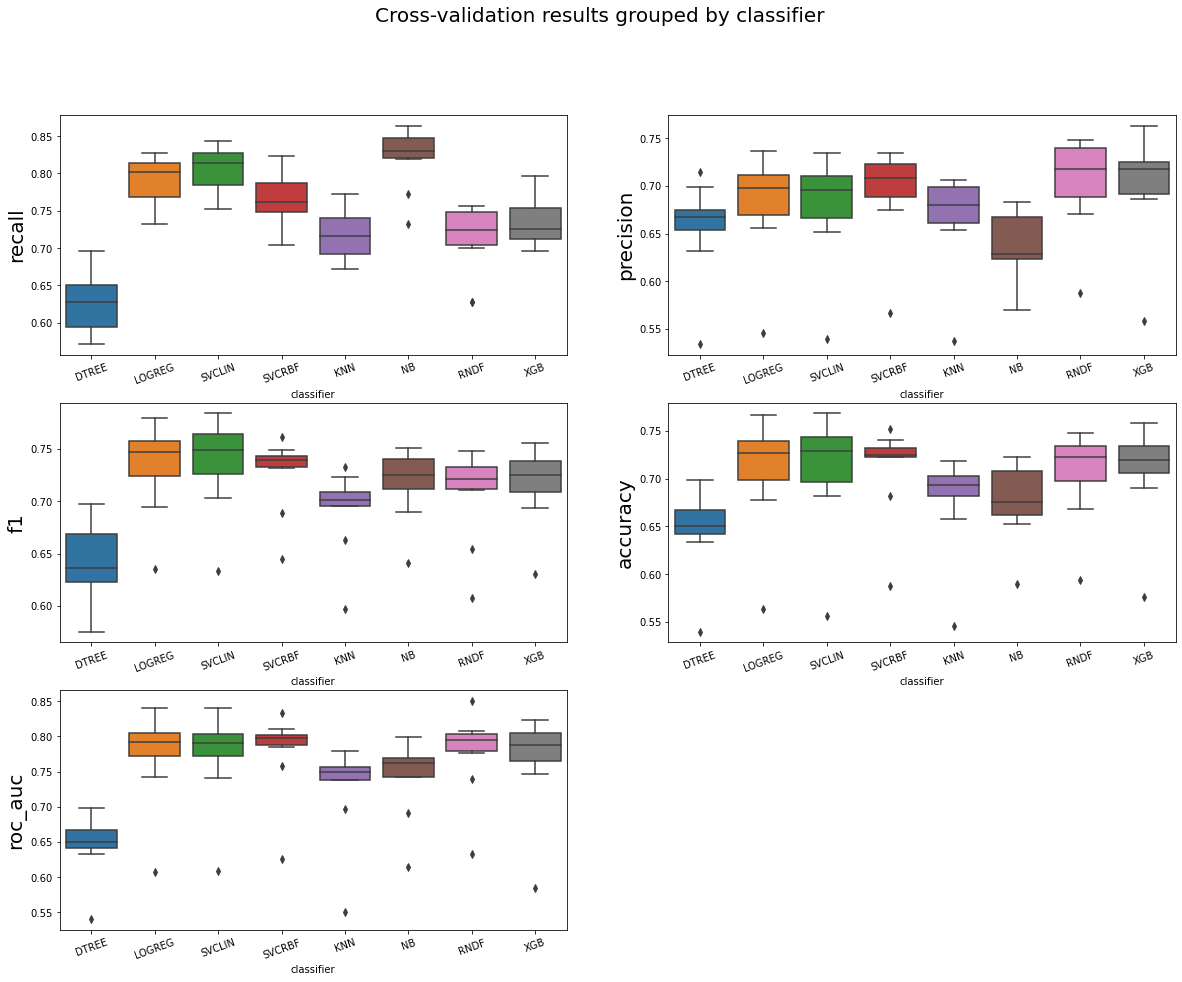

<Figure size 432x288 with 0 Axes>

In [19]:
#%% boxplot of results 

fig       = plt.figure(figsize = (20,15))
fig.tight_layout()

for i, metric in enumerate(df_xval_all.drop(['classifier'], axis = 1)):
    ax    = fig.add_subplot(3, 2, i+1)
    h     = sns.boxplot(y      = metric, 
                        x      = 'classifier', 
                        data   = df_xval_all,  
                        orient = 'v', 
                        ax     = ax)
    h.set_ylabel(metric,fontsize = 20)
    h.set_xticklabels(h.get_xticklabels(), rotation = 20)
    h.set_xlabel('classifier',fontsize = 10)
    plt.tick_params(labelsize = 10)

fig.suptitle('Cross-validation results grouped by classifier', fontsize = 20)

# save fig
fig_name  = 'x_train_xval_results.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()

plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(Path(fig_file))

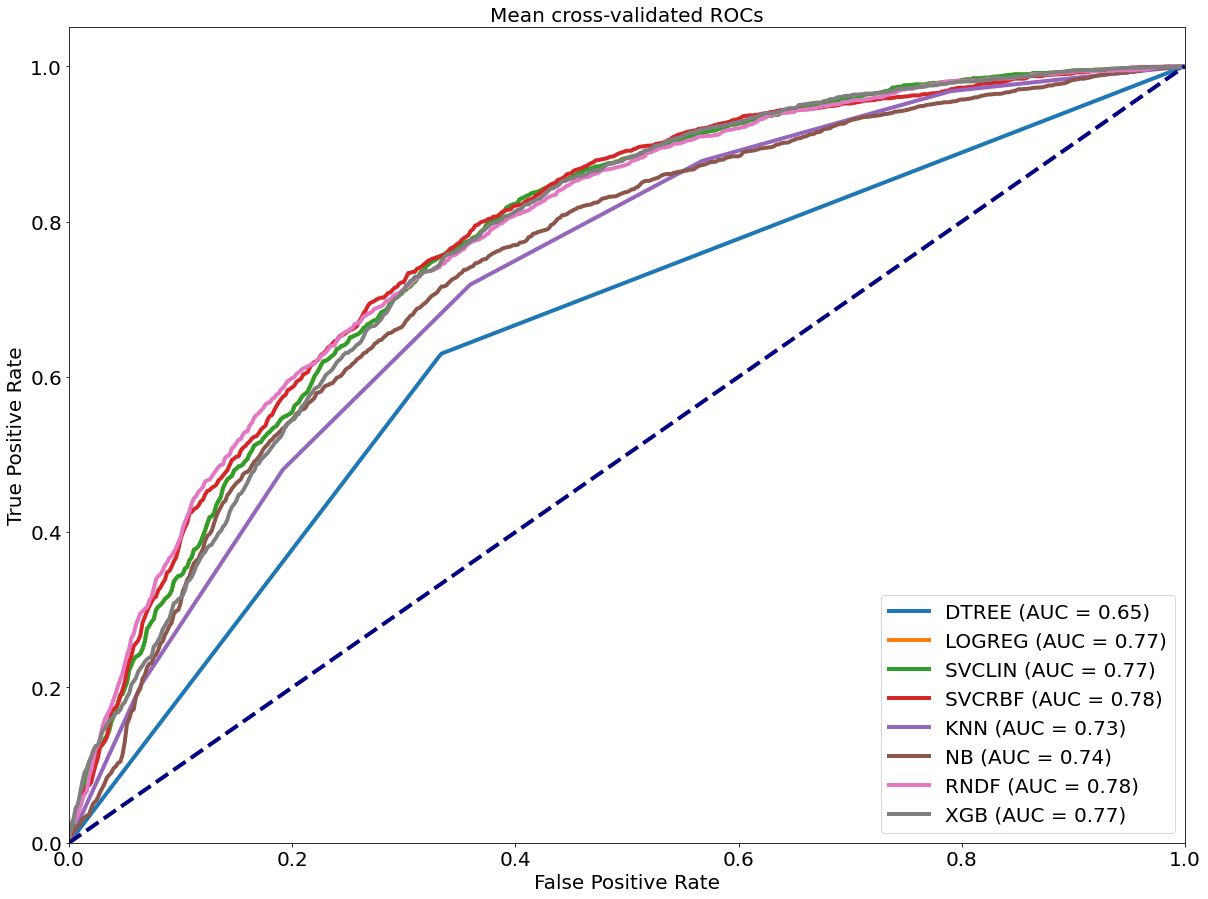

<Figure size 432x288 with 0 Axes>

In [21]:
#%% plot cross-validated ROC 

# Plot roc
plt.figure(figsize = [20,15])

for i in range(len(df_xval_roc.index)):
    
    # id classifier
    clf = df_xval_roc.loc[i, 'classifier']
    
    plt.plot(df_xval_roc.loc[i, 'fpr'], df_xval_roc.loc[i, 'tpr'], lw = 4, 
             label = df_xval_roc.loc[i, 'classifier'] + ' (AUC = %0.2f)' % df_xval_all[df_xval_all['classifier'] == clf]['roc_auc'].mean())

plt.plot([0, 1], [0, 1], color='navy', lw = 4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Mean cross-validated ROCs', fontsize = 20)
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(labelsize = 20)
plt.show()

# save fig
fig_name  = 'x_train_xval_roc.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()
plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(Path(fig_file))


In [22]:
# common params 

# define scalers to try
scalers     = [StandardScaler(), 
               RobustScaler(), 
               MinMaxScaler()]

# define cross-val method
cv          = StratifiedKFold(n_splits     = 10, 
                              shuffle      = True, 
                              random_state = 42)

# define scoring metric
metric      = 'f1'

### Logistic regression classifier

In [23]:
#%% log_reg clf

# base clf
logreg_clf  = LogisticRegression(n_jobs       = -1, 
                                 class_weight = 'balanced', 
                                 random_state = 42)

# create model pipeline 
pipe_logreg = Pipeline([('scaler',     StandardScaler()),
                        ('classifier', logreg_clf)])

# define param grid
grid_logreg =  {'scaler'                   : scalers,
                'classifier'               : [logreg_clf],
                'classifier__penalty'      : ['l2'],
                'classifier__C'            : np.logspace(-3, 3, 12),
                'classifier__max_iter'     : [20000], 
                'classifier__class_weight' : ['balanced']}

tune_logreg = GridSearchCV(pipe_logreg, 
                           cv                 = cv, 
                           param_grid         = grid_logreg, 
                           scoring            = metric,
                           refit              = True, 
                           return_train_score = False, 
                           n_jobs             = -1, 
                           verbose            = 1)

# perform tuning and extract best model
best_logreg = tune_logreg.fit(x_train, y_train).best_estimator_
print('tuning log_reg clf complete')


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s


tuning log_reg clf complete


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    8.2s finished


### Linear SVC

In [24]:
#%% svc_lin

# base clf
svc_lin_clf  = LinearSVC(max_iter     = 20000, 
                         class_weight = 'balanced', 
                         random_state = 42)

# create model pipeline 
pipe_svc_lin = Pipeline([('scaler',     StandardScaler()),
                         ('classifier', svc_lin_clf)])

# define param grid
grid_svc_lin = {'scaler'                   : scalers,
                'classifier'               : [svc_lin_clf],
                'classifier__penalty'      : ['l1', 'l2'],
                'classifier__loss'         : ['hinge', 'squared_hinge'],
                'classifier__C'            : np.logspace(-3, 3, 12),
                'classifier__max_iter'     : [20000], 
                'classifier__class_weight' : ['balanced']}

tune_svc_lin = GridSearchCV(pipe_svc_lin, 
                            cv                 = cv, 
                            param_grid         = grid_svc_lin, 
                            scoring            = metric,
                            refit              = True, 
                            return_train_score = False, 
                            n_jobs             = -1, 
                            verbose            = 1)

# perform tuning and extract best model
best_svc_lin = tune_svc_lin.fit(x_train, y_train).best_estimator_
print('tuning svc_lin clf complete')


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.7min finished


tuning svc_lin clf complete


In [25]:
# pickle the model 
file_model   = os.path.join(results_dir, 'best_svc_lin.sav')
dump(best_svc_lin, open(file_model, 'wb'))

Load test data 

In [26]:
# process test data 
df_test  = pd.read_csv(file_test)

# feats
x_test   = df_test.iloc[:, 1:]

# tweet id
t_id     = df_test.id.to_frame()

Retrain best model on the entire training set 

In [27]:
# default models

svc_rbf_final = svc_rbf.fit(x_train, y_train)
rndf_final    = rndf.fit(x_train, y_train)
xgb_final     = xgb.fit(x_train, y_train)
adb_final     = adb.fit(x_train, y_train)
gb_final      = gb.fit(x_train, y_train)

print('all done!')

In [30]:
# hyperparam tuned models 

svc_lin_final = best_svc_lin.fit(x_train, y_train) # good 
logreg_final  = best_logreg.fit(x_train, y_train)  # good
# rndf_final    = best_rndf.fit(x_train, y_train)    # bad 

print('all done!')

all done!


In [31]:
# gather models 

final_models = {'svc_lin': svc_lin_final,
                'logreg' : logreg_final, 
                'svc_rbf': svc_rbf_final,
                'rndf'   : rndf_final,
                'xgb'    : xgb_final, 
                'adb'    : adb_final, 
                'gb'     : gb_final}

In [32]:
#%% make prediction 

for name, model in final_models.items(): 
    
    # make prediction 
    pred     = model.predict(x_test)
    
    # convert to text labels
    pred     = ['SARCASM' if i == 1 else 'NOT_SARCASM' for i in pred]
    
    pred     = pd.DataFrame(pred, columns = ['predictions'])

    # concat into df
    answer   = pd.concat([t_id, pred], axis = 1)
    
    # construct file name 
    file_ans = Path(os.path.join(os.getcwd(), 'answer_' + name + '.txt'))
    
    # name the file, based on the classifier
    answer.to_csv(file_ans, header = None, index = None, sep = ',')
    
print('all predictions completed!')

all predictions completed!
